# Part 1: Build a Basic Chatbot

In [1]:
from audioop import reverse
from typing import Annotated

from dateutil.parser import parser
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

/tmp/ipykernel_1738/1760776747.py:1: DeprecationWarning: 'audioop' is deprecated and slated for removal in Python 3.13
  from audioop import reverse


In [2]:
from config import *
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="qwen-max")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

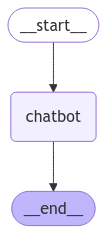

In [4]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: What do you know about LangGraph?
Assistant: LangGraph is a technology that combines the capabilities of large language models (LLMs) with graph neural networks (GNNs) to enhance the processing and understanding of complex, structured data. The idea behind LangGraph is to leverage the strengths of both LLMs and GNNs to better handle tasks that involve reasoning over relationships and structures in data, such as knowledge graphs, social networks, and other graph-structured information.

### Key Features and Benefits:

1. **Enhanced Reasoning:**
   - **Relational Understanding:** LangGraph can better understand and reason about relationships between entities, which is crucial for tasks like question answering, recommendation systems, and semantic search.
   - **Contextual Awareness:** By integrating the context-awareness of LLMs with the structural awareness of GNNs, LangGraph can provide more accurate and relevant results.

2. **Improved Data Representation:**
   - **Structured Da

# Part 2: 🛠️ Enhancing the Chatbot with Tools

In [4]:
from config import *
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': "Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 | by Kamal Dhungana | Medium Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 LangGraph — State, Node and Edge Explained Mainly, we will focus on various components of LangGraph: State, Node, and Edges, and how to build a complete graph from these components. Once we understand these components, we will be able to build relatively complex LangGraph-based agents. Each node represents a specific function or operation that processes the current state. Nodes can perform computations, modify the state, or generate outputs based on the input they receive. Follow 1.2K Followers Data scientist with a passion for AI, Regularly blogging about LLM and OpenAI's innovations,Sharing insights for AI community growth Follow"},
 {'url': 'https://blog.langchain

In [6]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatOpenAI(model_name="qwen-max")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [7]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [8]:
def route_tools(
        state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

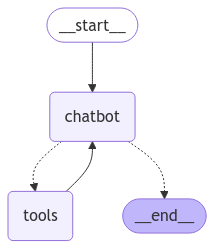

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 您好！有什么问题我可以帮助您吗？
User: What do you know about LangGraph?
Assistant: 
Assistant: [{"url": "https://github.com/langchain-ai/langgraph", "content": "GitHub - langchain-ai/langgraph: Build resilient language agents as graphs. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Let's build a tool-calling ReAct-style agent that uses a search tool! The simplest way to create a tool-calling agent in LangGraph is to use create_react_agent: Define the tools for the agent to use Define the tools for the agent to use This means that after tools is called, agent node is called next. workflow.add_edge(\"tools\", 'agent') Normal edge: after the tools are invoked, the graph should always return to the agent to decide what to do next LangGraph adds the input message to the internal state, then passes the state to the entrypoint node, \"agent\"."}, {"url": "https://www.langchain.com/langgraph", "content": "Build and

# Part 3: Adding Memory to the Chatbot

In [3]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [7]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="qwen-max")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [8]:
graph = graph_builder.compile(checkpointer=memory)

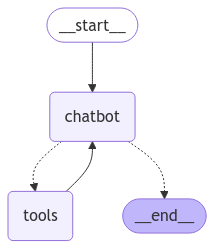

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [21]:
config = {"configurable": {"thread_id": "2"}}

In [22]:
user_input = "Hi there! My name is Will."
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! It's nice to meet you. How can I assist you today?


In [23]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Of course, Will! How can I assist you today?


In [24]:
user_input = "Remember my name?"

# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "3"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I'm sorry, but as an AI, I don't have the capability to remember personal information from previous conversations unless you've just told me in the current session. Could you please tell me your name again?


In [25]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='a325049d-e533-455e-802c-a870e3d81fd4'), AIMessage(content="Hello Will! It's nice to meet you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 213, 'total_tokens': 230, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'qwen-max', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-c2bde339-695c-4278-b936-147588a9824d-0', usage_metadata={'input_tokens': 213, 'output_tokens': 17, 'total_tokens': 230, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='5f733c4d-a91f-4d3b-abd1-d912aee6fec5'), AIMessage(content='Of course, Will! How can I assist you today?', add

# Part 4: Human-in-the-loop

In [15]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatOpenAI(model="qwen-max")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [16]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

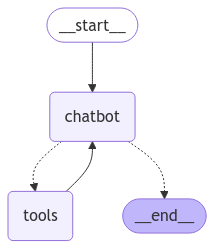

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_cb312d877f5b42eda1bcec)
 Call ID: call_cb312d877f5b42eda1bcec
  Args:
    query: I need some expert guidance for building an AI agent.


In [19]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [28]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})
events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_cb312d877f5b42eda1bcec)
 Call ID: call_cb312d877f5b42eda1bcec
  Args:
    query: I need some expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts recommend that you check out LangGraph to build your AI agent. It's noted for being more reliable and extensible compared to simpler autonomous agents. If you need further assistance or have more questions, feel free to ask!


# Part 5: Customizing State

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

In [4]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt


@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
        name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)


In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatOpenAI(model="qwen-max")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

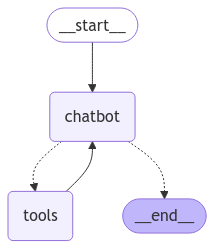

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_51af95c4d7554eadac9eb8)
 Call ID: call_51af95c4d7554eadac9eb8
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://github.com/langchain-ai/langgraph/releases", "content": "Releases · langchain-ai/langgraph · GitHub Search code, repositories, users, issues, pull requests... Releases: langchain-ai/langgraph Releases · langchain-ai/langgraph langgraph: release 0.2.70 (#3341) langgraph: add agent name to AI messages in create_react_agent (#3340) fix(langgraph): Dedupe input (right-side) messages in add_messages (#3338) Merge branch 'jacob/dedupe' of git

In [12]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_0f2fb2a2aed1413491a8f9)
 Call ID: call_0f2fb2a2aed1413491a8f9
  Args:
    name: LangGraph Release Date
    birthday: February 6, 2025
================================= Tool Message =================================
Name: human_assistance

null
================================== Ai Message ==================================

The latest release of LangGraph, version 0.2.70, was uploaded on February 6, 2025. This information has been verified and is accurate.


In [13]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{}

## Manually updating state

In [15]:
graph.update_state(config, {"name": "LangGraph (library)"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efeff72-64bd-6339-8006-0c76ddfd9eed'}}

In [16]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph (library)'}

# Part 6: Time Travel

In [24]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="qwen-max")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [25]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_282b3f5a7c784342bc64bf)
 Call ID: call_282b3f5a7c784342bc64bf
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://github.com/langchain-ai/langgraph", "content": "GitHub - langchain-ai/langgraph: Build resilient language agents as graphs. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Let's build a tool-calling ReAct-style agent that uses a search tool! The simplest way to create a tool-calling agent in LangGraph is to use create_react_agent: Define the tools for the agent to use Define the tools for the agent to use This means

In [26]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like an exciting project! Building an autonomous agent with LangGraph can be a rewarding experience, and it's a great way to explore the capabilities of language models in creating dynamic and interactive applications. Here are some steps and tips to get you started:

1. **Understand the Basics**: Make sure you have a good understanding of how LangGraph works, including its core concepts such as nodes, edges, and state. Familiarize yourself with the terminology and the architecture of a LangGraph application.

2. **Define the Agent's Purpose**: Clearly define what your autonomous agent will do. Will it perform a specific task, assist users, or perhaps gather information? Having a clear purpose will guide the design and implementation of your agent.


In [45]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 4:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  7 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
-------------------------------------------------------

In [33]:
print(to_replay.next)
print(to_replay.config)

('chatbot',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efeff7f-26dd-6dd8-8005-10d6caa3f092'}}


In [34]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like a great project! Building an autonomous agent with LangGraph can be both challenging and rewarding. Here are some steps and tips to get you started on creating your own autonomous agent:

1. **Define the Agent's Purpose**: Determine what tasks or problems your agent will solve. This could be anything from information retrieval, customer service, to more complex decision-making processes.

2. **Choose Your Tools and APIs**: Decide which external tools and APIs your agent will need to interact with. These might include search engines, databases, or other services that provide the data and capabilities required for the agent to perform its tasks.

3. **Design the Workflow**: Plan out the workflow of your agent, including how it will handle inputs,